# Calibrated microscopy in MEFL on experiment 2 (09/24/2023) with different lysates/co-culture conditions

In [1]:
import os
current_directory = os.getcwd()

import cytoflow as flow
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd
from scipy import stats
import seaborn as sns
%matplotlib inline

In [2]:
root = current_directory + "/expt09242023/"
test_other_root = current_directory + "/expt09182023/"
RedChannel   = "mCherry-A"
GreenChannel = "EGFP-A"

samples = ['WT', 'EGFP', 'mCherry', 'MEGF10_IgG', 'MEGF10_FT', 'Fcgamma_IgG', 'Fcgamma_FT']
files, inputs = dict(), dict()
for sample in samples:
    files[sample] = root + f'{sample}.fcs'
    inputs[(sample, 1, sample)] = files[sample] # (sampleKey, repKey, sampleNameKey)

tubes = []

for (sampleKey, repKey, sampleNameKey), filename in inputs.items():
    tube = flow.Tube(file = filename,
                     conditions = {'SampleType' : sampleKey,
                                   'Rep'    : repKey,
                                   'SampleName': sampleNameKey})
    if sampleKey in ['WT', 'EGFP', 'mCherry']:
        tube_other_expt = flow.Tube(file = test_other_root + f'{sampleKey}.fcs',
                    conditions = {'SampleType' : sampleKey,
                                'Rep'    : repKey+1,
                                'SampleName': sampleNameKey})
        tubes.append(tube_other_expt)

    tubes.append(tube)
    

import_op = flow.ImportOp(conditions = {'SampleType' : "category",
                                        'Rep'  : "int",
                                        'SampleName': "category"},
                          tubes = tubes)
ex = import_op.apply()
# Get number of events per sample
events_per_sample = ex.data.groupby('SampleName').size()
print("\nNumber of events per sample:")
print(events_per_sample)


# can do ex.query('SampleType == "WT"') for example


Number of events per sample:
SampleName
EGFP            35000
Fcgamma_FT     100000
Fcgamma_IgG    100000
MEGF10_FT      100000
MEGF10_IgG      97605
WT              60000
mCherry         60000
dtype: int64


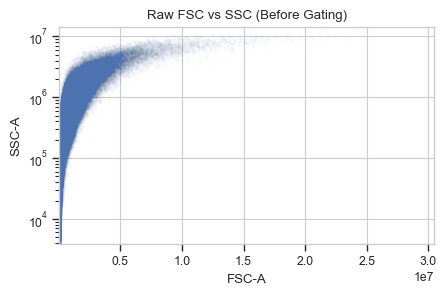

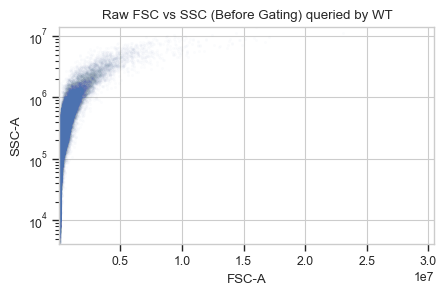

In [3]:
# First, let's look at the raw scatter plots for all samples before gating
scatter_view_raw = flow.ScatterplotView(
    xchannel='FSC-A',
    ychannel='SSC-A')
    # huefacet='SampleName')
scatter_view_raw.plot(ex, alpha=0.01)
plt.title('Raw FSC vs SSC (Before Gating)')
plt.yscale('log')
plt.show()

# First, let's look at the raw scatter plots for all samples before gating
scatter_view_raw = flow.ScatterplotView(
    xchannel='FSC-A',
    ychannel='SSC-A')
    # huefacet='SampleName')
scatter_view_raw.plot(ex.query('SampleType == "WT"'), alpha=0.01)
plt.title('Raw FSC vs SSC (Before Gating) queried by WT')
plt.yscale('log')
plt.show()



/Users/katie/opt/anaconda3/envs/cytoflow/lib/python3.8/site-packages/cytoflow/operations/base_op_views.py:373: CytoflowViewWarning: Setting 'huefacet' to 'Size'


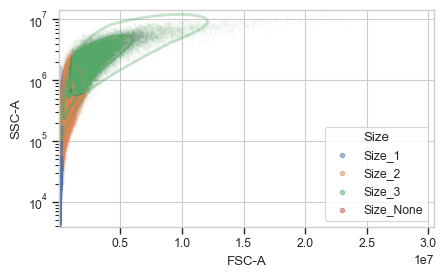

In [4]:
# Use GMMs to gate
GMMs = {}

GMMs['FSC and SSC'] = flow.GaussianMixtureOp(name = "Size",
                                channels = ["FSC-A","SSC-A"], 
                                scale = {"FSC-A": "log", "SSC-A" : "log"},
                                num_components = 3,   # by eyeballing the above plot
                                sigma = 2)
GMMs['FSC and SSC'].estimate(ex.query('SampleType == "WT"'))   # parameters associated with this instance 
gated_FSC_SSC = GMMs['FSC and SSC'].apply(ex)  

GMMs['FSC and SSC'].default_view().plot(gated_FSC_SSC, alpha=0.01)
plt.yscale('log')
plt.xscale('linear')



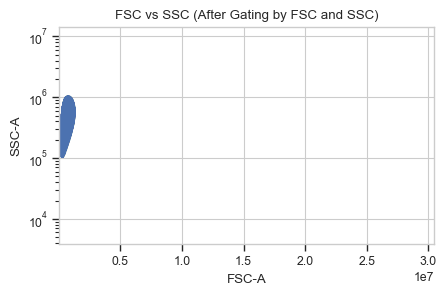


Number of events per sample:
SampleName
EGFP           17336
Fcgamma_FT     47504
Fcgamma_IgG    49848
MEGF10_FT      43381
MEGF10_IgG     57115
WT             31264
mCherry        23320
dtype: int64


In [5]:
morpho_string_FSC_SSC = "Size_2 == True"
scatter_view_raw = flow.ScatterplotView(
    xchannel='FSC-A',
    ychannel='SSC-A',
    subset = morpho_string_FSC_SSC)
    # huefacet='SampleName')
scatter_view_raw.plot(gated_FSC_SSC, alpha=0.01)
plt.title('FSC vs SSC (After Gating by FSC and SSC)')
plt.yscale('log')
plt.show()

events_per_sample = gated_FSC_SSC.data.query(morpho_string_FSC_SSC).groupby('SampleName').size()
print("\nNumber of events per sample:")
print(events_per_sample)

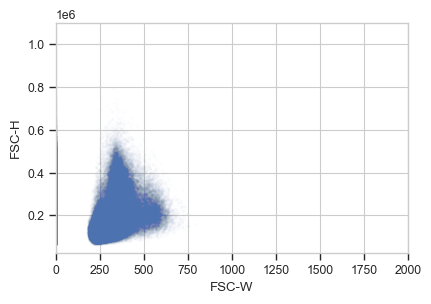

In [6]:
flow.ScatterplotView(xchannel = "FSC-W",
                     ychannel = "FSC-H",
                     subset = morpho_string_FSC_SSC).plot(gated_FSC_SSC, alpha = 0.01)
plt.ylim((25000,1100000));
plt.xlim((0,2000));
plt.show()

/Users/katie/opt/anaconda3/envs/cytoflow/lib/python3.8/site-packages/cytoflow/operations/base_op_views.py:373: CytoflowViewWarning: Setting 'huefacet' to 'HW_1'


(0.1, 1500.0)

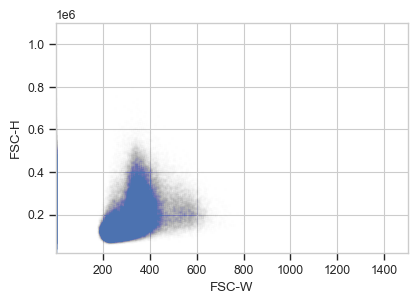

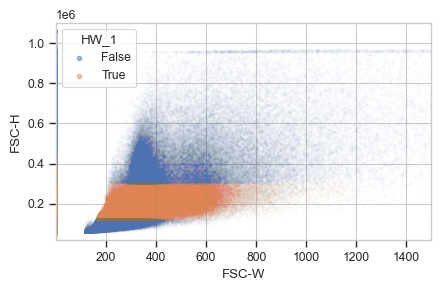

In [7]:
GMMs['height and width'] = flow.GaussianMixtureOp(name = "HW",
                                channels = ["FSC-W","FSC-H"],
                                num_components = 1,
                                sigma = 1)
GMMs['height and width'].estimate(gated_FSC_SSC.query('SampleType == "WT"'),subset = morpho_string_FSC_SSC)
# GMMs['height and width'].estimate(gated_FSC_SSC,subset = morpho_string_FSC_SSC)
GMMs['height and width'].default_view(subset = morpho_string_FSC_SSC).plot(gated_FSC_SSC, alpha = 0.005)
plt.ylim((20000,1100000))
plt.xlim((0.1,1500))
gated_height_width = GMMs['height and width'].apply(gated_FSC_SSC)
GMMs['height and width'].default_view().plot(gated_height_width, alpha=0.01)
plt.yscale('linear')
plt.xscale('linear')
plt.ylim((20000,1100000))
plt.xlim((0.1,1500))

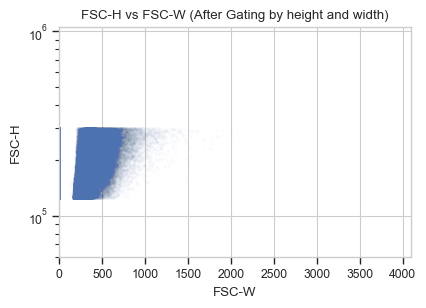

In [8]:
morpho_string_height_width = "HW_1 == True"
scatter_view_raw = flow.ScatterplotView(
    xchannel='FSC-W',
    ychannel='FSC-H',
    subset = morpho_string_height_width)
scatter_view_raw.plot(gated_height_width, alpha=0.01)
plt.title('FSC-H vs FSC-W (After Gating by height and width)')
plt.yscale('log')
plt.show()

In [9]:
# Get number of events per sample to confirm we haven't totally lost any sample types
events_per_sample = gated_height_width.data[gated_height_width.data.HW_1 == True].groupby('SampleName').size()
print("\nNumber of events per sample:")
print(events_per_sample)

MorphoString = 'Size_2 == True and HW_1 == True'



Number of events per sample:
SampleName
EGFP           14591
Fcgamma_FT     38381
Fcgamma_IgG    43071
MEGF10_FT      33892
MEGF10_IgG     46880
WT             25465
mCherry        19129
dtype: int64


## Autofluorescence and bleedthrough

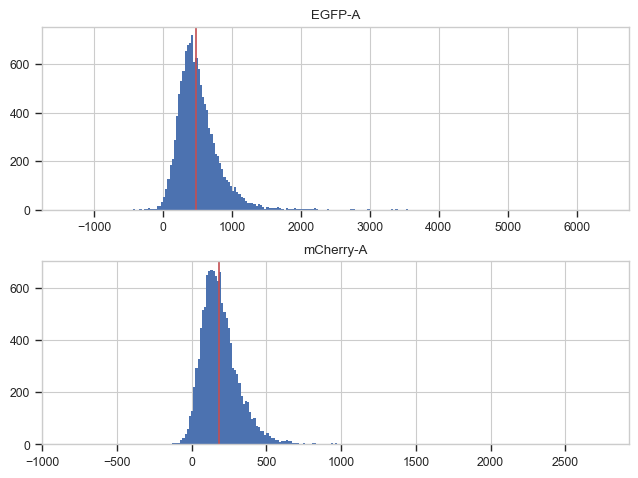

In [10]:
af_op = flow.AutofluorescenceOp()
af_op.blank_file = files['WT']
af_op.channels = [GreenChannel, RedChannel]

ex = gated_height_width
af_op.estimate(ex, subset=MorphoString)
af_op.default_view().plot(ex)
plt.rcParams["figure.figsize"] = [10,10]
ex_af = af_op.apply(ex)

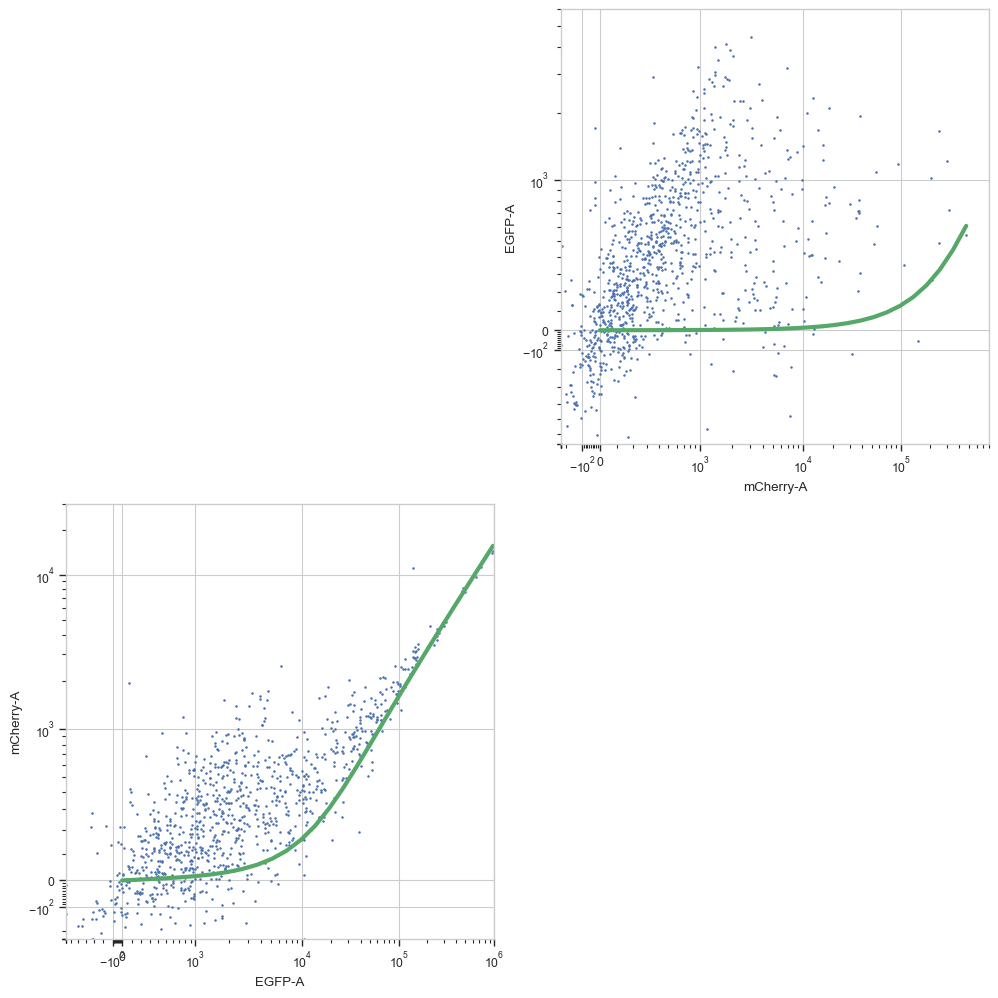

In [11]:
bl_op = flow.BleedthroughLinearOp()
bl_op.controls = {'EGFP-A' : files['EGFP'],
                  'mCherry-A' : files['mCherry']}
bl_op.estimate(ex_af, subset = MorphoString )
bl_op.default_view().plot(ex_af)
ex_bl = bl_op.apply(ex_af)

## Color gating

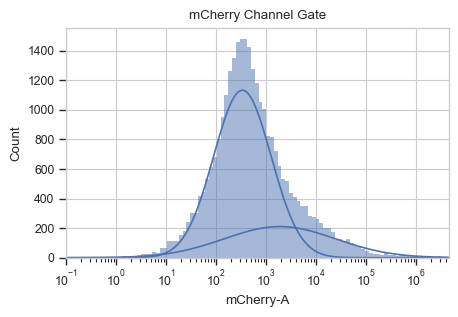

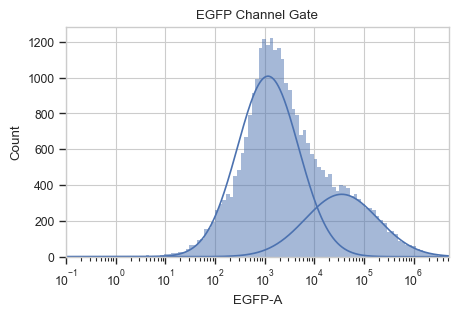

In [12]:
# Red Channel
GMMs['red'] = flow.GaussianMixtureOp(name="RedGate",
                               channels=[RedChannel], 
                               scale={RedChannel: "log"},
                               num_components=2,  # Assuming positive and negative populations (fluorescent red vs untransfected)
                               sigma=4)

# Estimate parameters of GMM using the red control sample
red_control = flow.ImportOp(tubes=[flow.Tube(file=files['mCherry'])]).apply()
GMMs['red'].estimate(red_control)

# Visualize the gate
GMMs['red'].default_view().plot(red_control)
plt.title("mCherry Channel Gate")
plt.show()

# Green Channel
GMMs['green'] = flow.GaussianMixtureOp(name="GreenGate",
                               channels=[GreenChannel], 
                               scale={GreenChannel: "log"},
                               num_components=2,  # Assuming positive and negative populations (fluorescent red vs untransfected)
                               sigma=2)

# Estimate parameters of GMM using the red control sample
green_control = flow.ImportOp(tubes=[flow.Tube(file=files['EGFP'])]).apply()
GMMs['green'].estimate(green_control)

# Visualize the gate
GMMs['green'].default_view().plot(green_control)
plt.title("EGFP Channel Gate")
plt.show()

In [13]:
# Apply red gate
gated_red = GMMs['red'].apply(ex_bl)

# Apply green gate
gated_green = GMMs['green'].apply(ex_bl)

# Apply both
gated = GMMs['green'].apply(gated_red)


# By comparing the following:
# gated.data.query('SampleName == "EGFP" and GreenGate_1 == True').min()
# gated.data.query('SampleName == "EGFP" and GreenGate_2 == True').min()
# it is apparent that GreenGate_2 == True is the gate where EGFP expression is high

# By comparing the following:
# gated.data.query('SampleName == "mCherry" and RedGate_1 == True').min()
# gated.data.query('SampleName == "mCherry" and RedGate_2 == True').min()
# it is apparent that RedGate_2 == True is the gate where mCherry expression is high

## Plot results

In [14]:
all_EGFP = gated.data.query(MorphoString + ' and SampleName == "EGFP"')
all_mCherry = gated.data.query(MorphoString + ' and SampleName == "mCherry"')
print(len(all_EGFP))  # number of EGFP samples after morpho gating
print(len(gated.data.query(MorphoString + ' and SampleName == "EGFP" and RedGate_1 == True')))  # ^ subsetted to RedGate == False (want this number HIGH)

print(len(all_mCherry))  # number of mCherry samples after morpho gating
print(len(gated.data.query(MorphoString + ' and SampleName == "mCherry" and GreenGate_2 == False')))  # ^ subsetted to GreenGate == False (want this number HIGH)

11585
9271
13660
12133


In [ ]:
print(len(gated.data.query(MorphoString + ' and SampleName == "Fcgamma_FT" and RedGate_2 == True and GreenGate_2 == True')))
print(len(gated.data.query(MorphoString + ' and SampleName == "Fcgamma_FT"')))

print(len(gated.data.query(MorphoString + ' and SampleName == "MEGF10_FT" and RedGate_2 == True and GreenGate_2 == True')))
print(len(gated.data.query(MorphoString + ' and SampleName == "MEGF10_FT"')))

# print(len(gated.data.query(MorphoString + ' and SampleName == "Fcgamma_IgG" and RedGate_2 == True and GreenGate_2 == True')))
# print(len(gated.data.query(MorphoString + ' and SampleName == "Fcgamma_IgG"')))

# print(len(gated.data.query(MorphoString + ' and SampleName == "MEGF10_IgG" and RedGate_2 == True and GreenGate_2 == True')))
# print(len(gated.data.query(MorphoString + ' and SampleName == "MEGF10_IgG"')))

FCgamma_IgG = gated.data.query(MorphoString + ' and SampleName == "Fcgamma_IgG"')
FCgamma_FT = gated.data.query(MorphoString + ' and SampleName == "Fcgamma_FT"')

MEGF10_IgG = gated.data.query(MorphoString + ' and SampleName == "MEGF10_IgG"')
MEGF10_FT = gated.data.query(MorphoString + ' and SampleName == "MEGF10_FT"')

# check WT! very few double positives as desired
print(len(gated.data.query(MorphoString + ' and SampleName == "WT" and RedGate_2 == True and GreenGate_2 == True')))
print(len(gated.data.query(MorphoString + ' and SampleName == "WT"')))

6932
31083
7818
26024


In [ ]:
# Sample data for 3 bars (for example, three categories: A, B, C)
data = {'Category': ['WT', 'FCgamma with IL-6 lysate', 'MEGF10 with IL-6 lysate'],
        'Value': [10, 25, 15]}

# Convert the data into a DataFrame
df = pd.DataFrame(data)

# Set the Seaborn style (for a more stunning look)
sns.set(style="whitegrid")

# Create a bar plot
plt.figure(figsize=(8, 6))
bar_plot = sns.barplot(x='Category', y='Value', data=df, palette='Blues_d', ci=None)

# Customize the plot
bar_plot.set_title('3-Bar Bar Chart', fontsize=16, fontweight='bold')
bar_plot.set_xlabel('Category', fontsize=14)
bar_plot.set_ylabel('Value', fontsize=14)
bar_plot.set_xticklabels(bar_plot.get_xticklabels(), fontsize=12)
bar_plot.set_yticklabels(bar_plot.get_yticklabels(), fontsize=12)

# Add data labels on top of the bars for extra clarity
for p in bar_plot.patches:
    bar_plot.annotate(f'{p.get_height()}', 
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='center', 
                      fontsize=14, color='black', 
                      xytext=(0, 5), textcoords='offset points')

# Show the plot
plt.tight_layout()
plt.show()


239
21253
